<a href="https://www.kaggle.com/code/manuelasaez/notebook7ac3a6aea3?scriptVersionId=176920419" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/test-file/tested.csv


**First, I read the data files and take a quick look at them:**
 


In [48]:
#There are three files in the data: (1) train.csv, (2) test.csv, and (3) gender_submission.csv.

# load data
# I will duplicate the files, just to test 2 differnet models: Random forest and KNeighborsClassifier
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
train_df_KN = pd.read_csv('/kaggle/input/titanic/train.csv')

test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
test_df_KN = pd.read_csv('/kaggle/input/titanic/test.csv')

x_gender = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# print the first 5 rows of the dataframes
display(train_df.head())  #column 'survived' 1--> survived, 0--> died
display(test_df.head())
#display(x_gender.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Second, I check the names of the data columns and explore them**
* I replace NaN values with the corresponding feature's mean value (this is to enable the use of sklearn.neighbors.KNeighborsClassifier). 
* I change the variables 'male' or 'female' to 0 or 1 respectively, to have numeric entries.
* Construct a pairplot with the data set to have a look of the behaviour and correlations


In [ ]:
column_names = train_df.columns
print(column_names)
#reemplazo los NaN por la media
train_mean_age = train_df['Age'].mean()
test_mean_age = test_df['Age'].mean()
train_mean_fare = train_df['Fare'].mean()
test_mean_fare = test_df['Fare'].mean()


train_df['Age'].fillna(train_mean_age, inplace=True)
test_df['Age'].fillna(test_mean_age, inplace=True)
train_df['Fare'].fillna(train_mean_fare, inplace=True)
test_df['Fare'].fillna(test_mean_fare, inplace=True)

train_df_KN['Age'].fillna(train_mean_age, inplace=True)
test_df_KN['Age'].fillna(test_mean_age, inplace=True)
train_df_KN['Fare'].fillna(train_mean_fare, inplace=True)
test_df_KN['Fare'].fillna(test_mean_fare, inplace=True)

train_df_KN['Sex'] = train_df_KN['Sex'].replace({'male': 0, 'female': 1})

my_palette = "Set1"  # Puedes elegir entre diferentes paletas, como "Set1", "Set2", "husl", etc.
# Define tu paleta de colores personalizada
train_df_KN['Survived'] = train_df_KN['Survived'].replace({0: '0', 1: '1'})

my_colors = {"0": "r", "1": "green"}

sns.pairplot(train_df_KN, vars= ['PassengerId',  'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch',  'Fare'], hue='Survived', height=2.5, diag_kind="kde",palette=my_colors)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


**From the plots, we can see that Sex, Fare, and Pclass are some of the most relevant features for determining survival or not.**

Bellow, I calculated the survival rates relative to each feature:


In [54]:
women = train_df.loc[train_df.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
men = train_df.loc[train_df.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of women who survived:", rate_women)
print("% of men who survived:", rate_men)

Pc1 = train_df.loc[train_df.Pclass == 1]["Survived"]
rate_Pc1 = sum(Pc1)/len(Pc1)
Pc2 = train_df.loc[train_df.Pclass == 2]["Survived"]
rate_Pc2 = sum(Pc2)/len(Pc2)
Pc3 = train_df.loc[train_df.Pclass == 3]["Survived"]
rate_Pc3 = sum(Pc3)/len(Pc3)

print("% of Pclass 1 who survived:", rate_Pc1)
print("% of Pclass 2 who survived:", rate_Pc2)
print("% of Pclass 3 who survived:", rate_Pc3)


# Calculate the maximum and minimum values of the 'Fare' column
fare_max = train_df['Fare'].max()
fare_min = train_df['Fare'].min()

print("Maximum Fare:", fare_max)
print("Minimum Fare:", fare_min)

# Calculate the mean of the 'Fare' column
fare_mean = train_df['Fare'].mean()

# Separate data into two groups based on fare being below or above the mean
below_mean = train_df[train_df['Fare'] < fare_mean]
above_mean = train_df[train_df['Fare'] >= fare_mean]

# Print the mean fare value and the sizes of the two groups
print("Mean Fare:", fare_mean)
print("Number of passengers below the mean fare:", len(below_mean))
print("Number of passengers above or equal to the mean fare:", len(above_mean))

Cheap_Fare = below_mean["Survived"]
rate_CF = sum(Cheap_Fare)/len(Cheap_Fare)
Exp_Fare = above_mean["Survived"]
rate_EF = sum(Exp_Fare)/len(Exp_Fare)
print("% of cheap fare tickets who survived:", rate_CF)
print("% of expensive fare tickets who survived:", rate_EF)



% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924
% of Pclass 1 who survived: 0.6296296296296297
% of Pclass 2 who survived: 0.47282608695652173
% of Pclass 3 who survived: 0.24236252545824846
Maximum Fare: 512.3292
Minimum Fare: 0.0
Mean Fare: 32.204207968574636
Number of passengers below the mean fare: 680
Number of passengers above or equal to the mean fare: 211
% of cheap fare tickets who survived: 0.3176470588235294
% of expensive fare tickets who survived: 0.5971563981042654


In [55]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 1)

In [56]:
x_train=train_df_KN[['Pclass', 'Sex',  'SibSp', 'Parch', 'Fare', 'Age']]
y_train=train_df_KN['Survived']
knn.fit(x_train, y_train)

print(x_train.shape)
print(y_train.shape)

(891, 6)
(891,)


In [57]:
test_df_KN['Sex'] = test_df_KN['Sex'].replace({'male': 0, 'female': 1})
x_test=test_df_KN[['Pclass', 'Sex',  'SibSp', 'Parch', 'Fare','Age']]
y_pred = knn.predict(x_test)

output_KN = pd.DataFrame({'PassengerId': test_df_KN.PassengerId, 'Survived': y_pred})
output_KN.to_csv('submission_KN.csv', index=False)
print(output_KN)

     PassengerId Survived
0            892        0
1            893        0
2            894        1
3            895        1
4            896        0
..           ...      ...
413         1305        0
414         1306        1
415         1307        0
416         1308        0
417         1309        1

[418 rows x 2 columns]


In [58]:
from sklearn.ensemble import RandomForestClassifier

y = train_df["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch","Fare","Age"]
X = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output_RF = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output_RF.to_csv('submission.csv', index=False)
print(output_RF)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


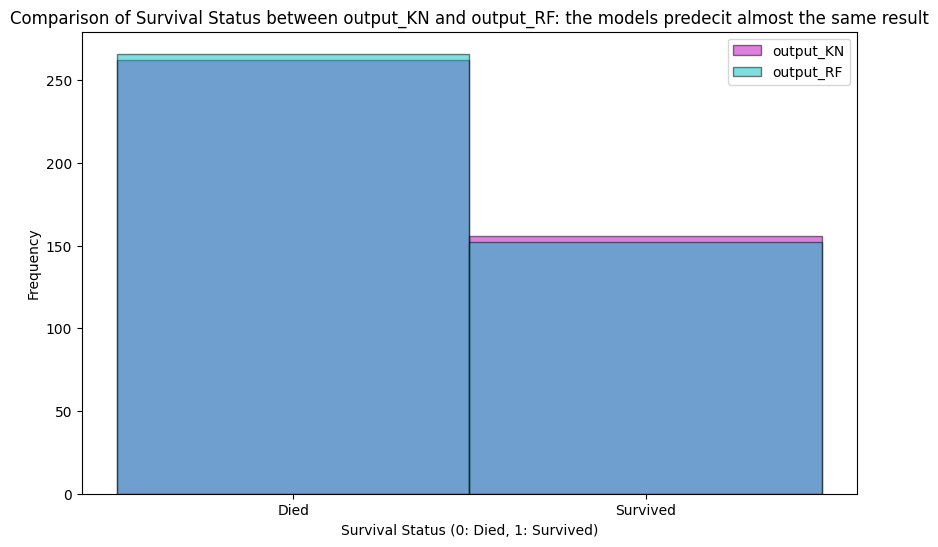

In [59]:
plt.figure(figsize=(10, 6))
plt.hist(output_KN['Survived'], bins=[-0.5, 0.5, 1.5], alpha=0.5, color='m', label='output_KN', edgecolor='black')
plt.hist(output_RF['Survived'], bins=[-0.5, 0.5, 1.5], alpha=0.5, color='c', label='output_RF', edgecolor='black')

# Configuración del gráfico
plt.xlabel('Survival Status (0: Died, 1: Survived)')
plt.ylabel('Frequency')

plt.title('Comparison of Survival Status between output_KN and output_RF: the models predecit almost the same result')
plt.xticks([0, 1], ['Died', 'Survived'])
plt.legend()

# Mostrar el gráfico
plt.show()